In [1]:
import numpy as np
import random
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from derivations_densities import gen_tau, gen_beta, compdS

In [37]:
extracted_coefficients_directory = '../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)#[0:B_zeta.shape[0]]
n = B_zeta.shape[0]
p = B_zeta.shape[1]

BoB = B_zeta**2
tau_start = 0.0001
beta = np.zeros(p)
theta=2.5
J = [5000,10000]
tBB = B_zeta.T.dot(B_zeta)
#dS2_old, ddS2_old, S2_old, S_old = dev.generate_dS2_ddS2_S2_S(Lambda_old, BoB)

In [38]:
# initialize Lambda
betaBt = beta.dot(B_zeta.T)

In [39]:
W = np.array([B_zeta[i,:].dot(B_zeta[i,:]) for i in range(0, n)])

In [40]:
def compdS(tau, W):
    tildeW = tau*W
    S2 = 1/(1+tildeW)
    dS2 = -tildeW/((1+tildeW)**2)
    ddS2 = -tildeW/((1+tildeW)**2) + 2*(tildeW**2)/((1+tildeW)**3)
    
    S = np.sqrt(S2)
    return(S2, dS2, ddS2, S)

def dlogFcu(u, B, S2, dS2, z, beta, theta, betaBt):
    p = B.shape[1]
    return( - 0.5*np.sum(dS2/S2) 
            - 0.5*np.sum((z**2)*(-dS2/(S2**2)))
            + np.sum(betaBt*((-0.5*dS2/(S2**1.5))*z)) 
            - (0.5*p - 0.5)
            + 0.5*(beta.dot(beta))/np.exp(u) 
            - 0.5*(np.exp(u)/theta)**0.5)

def ddlogFcu(u, B, S2, dS2, ddS2, z, beta, theta, betaBt):
    return( - 0.5*np.sum(ddS2/S2 - (dS2**2)/(S2**2)) 
           - 0.5*np.sum((z**2)*(2*(dS2**2)/(S2**3)
           - ddS2/(S2**2)))
           + np.sum(betaBt*(0.75*(dS2**2)/(S2**(2.5)) - 0.5*ddS2/(S2**1.5))*z)
           - 0.5*(beta.dot(beta)/np.exp(u))  
           - 0.25*(np.exp(u)/theta)**(0.5))

def logFCu(u,B,S2,z,beta,theta, betaBt):
    p = B.shape[1]
    return(  - 0.5*np.sum(np.log(S2)) 
           - 0.5*np.sum(z**2/S2)
           + np.sum(B.dot(beta)*z/np.sqrt(S2)) 
           - u*(0.5*p - 0.5) 
           - 0.5*(beta.dot(beta))/np.exp(u) 
           - (np.exp(u)/theta)**0.5)

def genbeta(z,u,B,tBB,S):
    p = tBB.shape[0]
    Sigmabeta = np.linalg.inv(tBB + np.identity(p)/np.exp(u))
    mubeta = Sigmabeta.dot(B_zeta.T).dot(S*z)
    #Sigmabetainv = tBB + np.identity(p)/np.exp(u)
    #L = np.linalg.cholesky(Sigmabetainv)
    #v = L.T.dot(1/np.random.normal(0,1,p))
    #eta = B_zeta.T.dot(z/np.sqrt(S2))
    #w = L.dot(1/eta)
    #mubeta = L.T.dot(1/w)
    #beta = mubeta + v
    beta = np.random.multivariate_normal(mubeta, Sigmabeta, 1).reshape(B.shape[1],)
    return(beta)

def gen_tau(tau_old,W,B,z,beta,theta, betaBt):
    S2,dS2,ddS2,S = compdS(tau_old,W)
    dlu = dlogFcu(np.log(tau_old), B_zeta, S2, dS2, z, beta, theta, betaBt)
    ddlu = ddlogFcu(np.log(tau_old), B_zeta, S2, dS2, ddS2, z, beta, theta, betaBt)
    sigma2u = -1/ddlu

    if sigma2u < np.finfo(float).eps:
        decision_criterion = float('-inf')
        return(0, decision_criterion , S2, dS2, ddS2, S)  
    else:
        muu = sigma2u*dlu + np.log(tau_old)
        unew = np.random.normal(0,1,1)*np.sqrt(sigma2u) + muu
        S2_new, dS2_new, ddS2_new, S_new = compdS(np.exp(unew),W)
        dlunew = dlogFcu(unew, B_zeta, S2_new, dS2_new, z, beta, theta, betaBt)
        ddlunew = ddlogFcu(unew, B_zeta, S2_new, dS2_new, ddS2_new, z, beta, theta, betaBt)
        sigma2unew = -1/ddlunew
        muunew = sigma2unew*dlunew + unew
        fcnew = logFCu(unew, B, S2_new, z, beta, theta, betaBt)
        fcold = logFCu(np.log(tau_old), B, S2, z, beta, theta, betaBt)
        proposalnew = -0.5*np.log(sigma2u) - 0.5*((unew - muu)**2)/sigma2u
        proposalold = -0.5*np.log(sigma2unew) - 0.5*((np.log(tau_old) - muunew)**2)/sigma2unew
        decision_criterion = fcnew - fcold - proposalnew + proposalold
        return(np.exp(unew), decision_criterion , S2_new, dS2_new, ddS2_new, S_new)


In [41]:
S2, dS2, ddS2, S = compdS(tau_start, W)

In [42]:
tau_old = tau_start
all_taus = []
tau_acc = []
all_betas = []
for i in [0,1]:
    if i == 0:
        print('warm-up phase')
    elif i == 1:
        print('sampling phase')
    for j in tqdm(range(0, J[i])):
        
        # sample beta
        betanew = genbeta(z,np.log(tau_old),B_zeta,tBB,S)
        all_betas.append(betanew)
        
        betaBt = B_zeta.dot(betanew)
        tau_new, decision_criterion , S2_new, dS2_new, ddS2_new, S_new = gen_tau(tau_old, W, B_zeta, z, betanew, theta, betaBt)
        
        if np.log(np.random.uniform(0,1,1)) <= decision_criterion:
            tau_old, S2, dS2, ddS2, S = tau_new.copy(), S2_new.copy(), dS2_new.copy(), ddS2_new.copy(), S_new.copy()
            all_taus.append(tau_old)
            tau_acc.append(1)
        else:
            all_taus.append(tau_old)
            tau_acc.append(0)
        if j%1000 == 0:
            print('acceptance rate for last 1000 iterates:' + str(np.mean(tau_acc[-1000:])))           

  0%|          | 0/5000 [00:00<?, ?it/s]

warm-up phase
acceptance rate for last 1000 iterates:0.0


  1%|          | 32/5000 [00:04<11:18,  7.32it/s]<ipython-input-40-7f0e035a5c30>:62: RuntimeWarning: overflow encountered in exp
  S2_new, dS2_new, ddS2_new, S_new = compdS(np.exp(unew),W)
<ipython-input-40-7f0e035a5c30>:4: RuntimeWarning: invalid value encountered in true_divide
  dS2 = -tildeW/((1+tildeW)**2)
<ipython-input-40-7f0e035a5c30>:5: RuntimeWarning: invalid value encountered in true_divide
  ddS2 = -tildeW/((1+tildeW)**2) + 2*(tildeW**2)/((1+tildeW)**3)
<ipython-input-40-7f0e035a5c30>:16: RuntimeWarning: overflow encountered in exp
  + 0.5*(beta.dot(beta))/np.exp(u)
<ipython-input-40-7f0e035a5c30>:17: RuntimeWarning: overflow encountered in exp
  - 0.5*(np.exp(u)/theta)**0.5)
<ipython-input-40-7f0e035a5c30>:24: RuntimeWarning: overflow encountered in exp
  - 0.5*(beta.dot(beta)/np.exp(u))
<ipython-input-40-7f0e035a5c30>:25: RuntimeWarning: overflow encountered in exp
  - 0.25*(np.exp(u)/theta)**(0.5))
<ipython-input-40-7f0e035a5c30>:29: RuntimeWarning: divide by zero encoun

KeyboardInterrupt: 

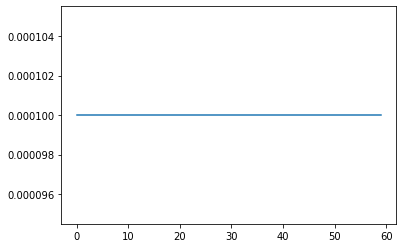

In [43]:
plt.plot(all_taus)

In [9]:
print('\nAcceptance rate for tau: ' + str(np.mean(tau_acc[J[0]:])))


Acceptance rate for tau: 0.8316


In [10]:
np.save('../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Ridge/taus.npy', np.array(all_taus[J[1]:]))
np.save('../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Ridge/betas.npy', np.array(all_betas[J[1]:]))